# Bisección JPSR

## Unico

In [5]:
import os
import subprocess
import uproot
import pandas as pd

# Configuración
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\build\Release"
exec_file = "PCM.exe"
root_filename = "Sim.root"
mac_template = """\
/run/initialize
/gun/energy {energy} keV
/det/t {thickness:.2f} nm
/run/reinitializeGeometry
/run/beamOn 10000
"""

# Función para crear y guardar el archivo .mac
def create_mac_file(energy, thickness):
    mac_file_path = os.path.join(sim_dir, "bisection.mac")
    mac_content = mac_template.format(energy=energy, thickness=thickness)
    with open(mac_file_path, 'w') as f:
        f.write(mac_content)
    return mac_file_path

# Función para ejecutar la simulación
def run_simulation(mac_file_path):
    try:
        subprocess.run([os.path.join(sim_dir, exec_file), mac_file_path], cwd=sim_dir, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error al ejecutar la simulación: {e}")

# Función para contar eventos en el archivo ROOT usando uproot y pandas
def count_events_from_root():
    file_path = os.path.join(sim_dir, root_filename)
    if not os.path.isfile(file_path):
        print("Error: El archivo ROOT no existe.")
        return -1
    
    try:
        with uproot.open(file_path) as file:
            tree = file["G4_PCM"]
            df = tree.arrays(library="pd")
        
        if 'Energy' not in df.columns:
            print("Error: La columna 'Energy' no se encontró en el DataFrame.")
            return -1
        
        # Contar eventos con energía mayor a 0
        return len(df[df['Energy'] > 0])

    except Exception as e:
        print(f"Error al procesar el archivo ROOT: {e}")
        return -1

# Función para la optimización por bisección
def bisection_optimization(initial_energy, t_min, t_max, target_count=4000, tol=500, tol_min=1):
    while (t_max - t_min) > tol_min:
        t_mid = (t_min + t_max) / 2
        mac_file_path = create_mac_file(initial_energy, t_mid)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            print("Error: No se encontró el archivo ROOT o la ntuple.")
            break

        if event_count < (target_count - tol):
            # Si el conteo es menor que el objetivo - tolerancia, ajustar el límite superior
            t_max = t_mid  # Reducir límite superior
        elif event_count > (target_count + tol):
            # Si el conteo es mayor que el objetivo + tolerancia, ajustar el límite inferior
            t_min = t_mid  # Aumentar límite inferior
        else:
            # El conteo está dentro del rango objetivo
            return t_mid

    return (t_min + t_max) / 2

# Parámetros iniciales
initial_energy = 0.006  # keV
t_min = 0  # nm
t_max = 20000000  # nm

# Ejecutar optimización
optimal_t = bisection_optimization(initial_energy, t_min, t_max)
print(f"Optimización completada: t óptimo = {optimal_t} nm")


Optimización completada: t óptimo = 7.152557373046875 nm


# Multiples

In [17]:
import os
import subprocess
import uproot
import pandas as pd
from tqdm import tqdm

# Configuración
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\build\Release"
exec_file = "PCM.exe"
root_filename = "Sim.root"
mac_template = """\
/run/initialize
/gun/energy {energy} keV
/det/t {thickness:.2f} nm
/run/reinitializeGeometry
/run/beamOn 10000
"""

# Función para crear y guardar el archivo .mac
def create_mac_file(energy, thickness):
    mac_file_path = os.path.join(sim_dir, "bisection.mac")
    mac_content = mac_template.format(energy=energy, thickness=thickness)
    with open(mac_file_path, 'w') as f:
        f.write(mac_content)
    return mac_file_path

# Función para ejecutar la simulación
def run_simulation(mac_file_path):
    subprocess.run([os.path.join(sim_dir, exec_file), mac_file_path], cwd=sim_dir, check=True)

# Función para contar eventos en el archivo ROOT usando uproot y pandas
def count_events_from_root():
    file_path = os.path.join(sim_dir, root_filename)
    if not os.path.isfile(file_path):
        return -1
    
    try:
        with uproot.open(file_path) as file:
            tree = file["G4_PCM"]
            df = tree.arrays(library="pd")
        
        if 'Energy' not in df.columns:
            return -1
        
        # Contar eventos con energía mayor a 0
        return len(df[df['Energy'] > 0])

    except:
        return -1

# Función para la optimización por bisección
def bisection_optimization(initial_energy, t_min, t_max, target_count=4000, tol=500, tol_min=1):
    while (t_max - t_min) > tol_min:
        t_mid = (t_min + t_max) / 2
        mac_file_path = create_mac_file(initial_energy, t_mid)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            break

        if event_count < (target_count - tol):
            t_max = t_mid  # Reducir límite superior
        elif event_count > (target_count + tol):
            t_min = t_mid  # Aumentar límite inferior
        else:
            return t_mid

    return (t_min + t_max) / 2

# Leer valores de energía del archivo CSV
energy_csv_path = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\energy_values.csv"
energy_values = pd.read_csv(energy_csv_path)

# Parámetros para la optimización
t_min = 0  # nm
t_max = 20000000  # nm

# Archivo de salida para guardar los resultados
output_file = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\optimization_results.csv"

# Realizar optimización para cada valor de energía y guardar resultados con barra de progreso
results = []
previous_t = None  # Inicializar para guardar el grosor óptimo previo

for energy in tqdm(energy_values['Energy'], desc="Optimizando", unit="energía"):
    if previous_t is not None:
        mac_file_path = create_mac_file(energy, previous_t)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            continue
        
        if abs(event_count - 4000) <= 500:
            results.append({'Energy': energy, 'Optimal_t': previous_t})
            continue
        else:
            optimal_t = bisection_optimization(energy, t_min, t_max)
            results.append({'Energy': energy, 'Optimal_t': optimal_t})
            previous_t = optimal_t
    else:
        optimal_t = bisection_optimization(energy, t_min, t_max)
        results.append({'Energy': energy, 'Optimal_t': optimal_t})
        previous_t = optimal_t

# Crear un DataFrame para los resultados y guardarlos en un archivo CSV
results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)


Optimizando: 100%|██████████| 177/177 [28:27<00:00,  9.65s/energía]


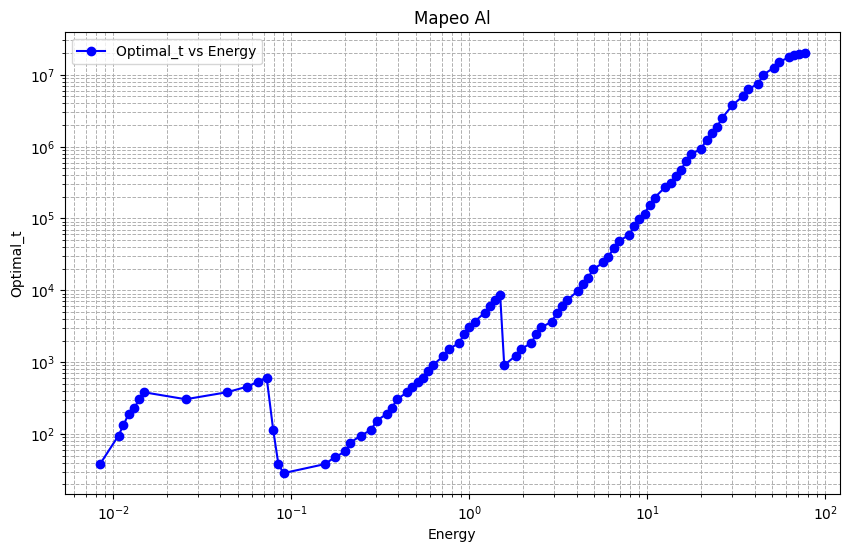

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer el archivo CSV
csv_file = 'MapeoAl.csv'
df = pd.read_csv(csv_file)

# Asumir que el archivo tiene columnas 'Energy' y 'Optimal_t'
energy_col = 'Energy'
optimal_t_col = 'Optimal_t'

# Comprobar que las columnas están presentes
if energy_col not in df.columns or optimal_t_col not in df.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in the CSV file")

# Extraer los datos
energy = df[energy_col].values
optimal_t = df[optimal_t_col].values

# Filtrar valores de 'Optimal_t' adyacentes repetidos, manteniendo 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

energy_filtered, optimal_t_filtered = remove_repeated_thickness(energy, optimal_t)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos filtrados
plt.plot(energy_filtered, optimal_t_filtered, 'o-', color='blue', label='Optimal_t vs Energy')

# Configurar escalas logarítmicas
plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
plt.xlabel('Energy')
plt.ylabel('Optimal_t')
plt.title('Mapeo Al')
plt.legend()

# Mostrar la cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# # Guardar el gráfico como archivo PNG
# plt.savefig('filtered_log_log_plot.png')

# Mostrar el gráfico
plt.show()


### Suena feo cuando acaba (Si range)

In [6]:
import os
import subprocess
import uproot
import pandas as pd
from tqdm import tqdm
import winsound  # Importar para reproducir sonido en Windows

# Configuración
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\build\Release"
exec_file = "PCM.exe"
root_filename = "Sim.root"
mac_template = """\
/run/initialize
/gun/energy {energy} keV
/det/t {thickness:.2f} nm
/run/reinitializeGeometry
/run/beamOn 10000
"""

# Función para crear y guardar el archivo .mac
def create_mac_file(energy, thickness):
    mac_file_path = os.path.join(sim_dir, "bisection.mac")
    mac_content = mac_template.format(energy=energy, thickness=thickness)
    with open(mac_file_path, 'w') as f:
        f.write(mac_content)
    return mac_file_path

# Función para ejecutar la simulación
def run_simulation(mac_file_path):
    subprocess.run([os.path.join(sim_dir, exec_file), mac_file_path], cwd=sim_dir, check=True)

# Función para contar eventos en el archivo ROOT usando uproot y pandas
def count_events_from_root():
    file_path = os.path.join(sim_dir, root_filename)
    if not os.path.isfile(file_path):
        return -1
    
    try:
        with uproot.open(file_path) as file:
            tree = file["G4_PCM"]
            df = tree.arrays(library="pd")
        
        if 'Energy' not in df.columns:
            return -1
        
        # Contar eventos con energía mayor a 0
        return len(df[df['Energy'] > 0])

    except:
        return -1

# Función para la optimización por bisección
def bisection_optimization(initial_energy, t_min, t_max, target_count=4000, tol=500, tol_min=1):
    while (t_max - t_min) > tol_min:
        t_mid = (t_min + t_max) / 2
        mac_file_path = create_mac_file(initial_energy, t_mid)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            break

        if event_count < (target_count - tol):
            t_max = t_mid  # Reducir límite superior
        elif event_count > (target_count + tol):
            t_min = t_mid  # Aumentar límite inferior
        else:
            return t_mid

    return (t_min + t_max) / 2

# Leer valores de energía del archivo CSV
energy_csv_path = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\energy_values.csv"
energy_values = pd.read_csv(energy_csv_path)

# Parámetros para la optimización
t_min = 5  # nm
t_max = 90000000  # nm

# Archivo de salida para guardar los resultados
output_file = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\optimization_results.csv"

# Realizar optimización para cada valor de energía y guardar resultados con barra de progreso
results = []
previous_t = None  # Inicializar para guardar el grosor óptimo previo

for energy in tqdm(energy_values['Energy'], desc="Optimizando", unit="energía"):
    if previous_t is not None:
        mac_file_path = create_mac_file(energy, previous_t)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            continue
        
        if abs(event_count - 4000) <= 500:
            results.append({'Energy': energy, 'Optimal_t': previous_t})
            continue
        else:
            optimal_t = bisection_optimization(energy, t_min, t_max)
            results.append({'Energy': energy, 'Optimal_t': optimal_t})
            previous_t = optimal_t
    else:
        optimal_t = bisection_optimization(energy, t_min, t_max)
        results.append({'Energy': energy, 'Optimal_t': optimal_t})
        previous_t = optimal_t

# Crear un DataFrame para los resultados y guardarlos en un archivo CSV
results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)

# Reproducir un sonido al finalizar el proceso
def play_sound():
    duration = 3000  # Duración en milisegundos (1 segundo)
    frequency = 440  # Frecuencia en Hz (La4)
    winsound.Beep(frequency, duration)

# Llamar a la función para reproducir el sonido
play_sound()


Optimizando:   0%|          | 0/911 [00:00<?, ?energía/s]

Optimizando: 100%|██████████| 911/911 [49:05<00:00,  3.23s/energía]  


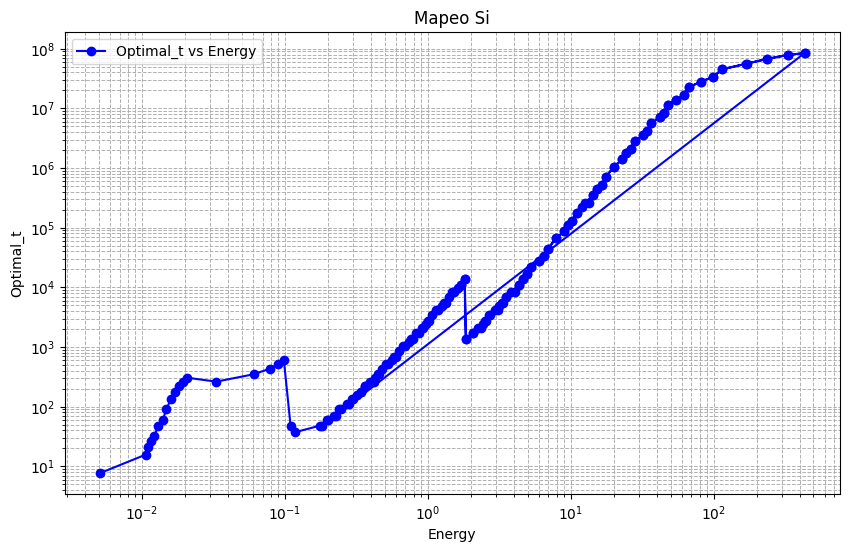

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer el archivo CSV
csv_file = 'MapeoSi.csv'
df = pd.read_csv(csv_file)

# Asumir que el archivo tiene columnas 'Energy' y 'Optimal_t'
energy_col = 'Energy'
optimal_t_col = 'Optimal_t'

# Comprobar que las columnas están presentes
if energy_col not in df.columns or optimal_t_col not in df.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in the CSV file")

# Extraer los datos
energy = df[energy_col].values
optimal_t = df[optimal_t_col].values

# Filtrar valores de 'Optimal_t' adyacentes repetidos, manteniendo 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

energy_filtered, optimal_t_filtered = remove_repeated_thickness(energy, optimal_t)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos filtrados
plt.plot(energy_filtered, optimal_t_filtered, 'o-', color='blue', label='Optimal_t vs Energy')

# Configurar escalas logarítmicas
plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
plt.xlabel('Energy')
plt.ylabel('Optimal_t')
plt.title('Mapeo Si')
plt.legend()

# Mostrar la cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# # Guardar el gráfico como archivo PNG
# plt.savefig('filtered_log_log_plot.png')

# Mostrar el gráfico
plt.show()


### Pone Spotify cuando acaba

In [18]:
import time
import pyautogui
import pygetwindow as gw
import os
import subprocess
import uproot
import pandas as pd
from tqdm import tqdm

# Configuración
sim_dir = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\build\Release"
exec_file = "PCM.exe"
root_filename = "Sim.root"
mac_template = """\
/run/initialize
/gun/energy {energy} keV
/det/t {thickness:.2f} nm
/run/reinitializeGeometry
/run/beamOn 10000
"""

# Función para crear y guardar el archivo .mac
def create_mac_file(energy, thickness):
    mac_file_path = os.path.join(sim_dir, "bisection.mac")
    mac_content = mac_template.format(energy=energy, thickness=thickness)
    with open(mac_file_path, 'w') as f:
        f.write(mac_content)
    return mac_file_path

# Función para ejecutar la simulación
def run_simulation(mac_file_path):
    subprocess.run([os.path.join(sim_dir, exec_file), mac_file_path], cwd=sim_dir, check=True)

# Función para contar eventos en el archivo ROOT usando uproot y pandas
def count_events_from_root():
    file_path = os.path.join(sim_dir, root_filename)
    if not os.path.isfile(file_path):
        return -1
    
    try:
        with uproot.open(file_path) as file:
            tree = file["G4_PCM"]
            df = tree.arrays(library="pd")
        
        if 'Energy' not in df.columns:
            return -1
        
        # Contar eventos con energía mayor a 0
        return len(df[df['Energy'] > 0])

    except:
        return -1

# Función para la optimización por bisección
def bisection_optimization(initial_energy, t_min, t_max, target_count=4000, tol=500, tol_min=1):
    while (t_max - t_min) > tol_min:
        t_mid = (t_min + t_max) / 2
        mac_file_path = create_mac_file(initial_energy, t_mid)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            break

        if event_count < (target_count - tol):
            t_max = t_mid  # Reducir límite superior
        elif event_count > (target_count + tol):
            t_min = t_mid  # Aumentar límite inferior
        else:
            return t_mid

    return (t_min + t_max) / 2

# Leer valores de energía del archivo CSV
energy_csv_path = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\energy_values.csv"
energy_values = pd.read_csv(energy_csv_path)

# Parámetros para la optimización
t_min = 0  # nm
t_max = 20000000  # nm

# Archivo de salida para guardar los resultados
output_file = r"C:\Users\conej\Documents\Universidad\Geant4\Projects\Git\G4-PCM\optimization_results.csv"

# Función para activar la ventana de Spotify y reproducir música
def activate_spotify_window():
    try:
        # Buscar la ventana de Spotify
        spotify_windows = gw.getWindowsWithTitle('Spotify Premium')
        
        if spotify_windows:
            spotify_window = spotify_windows[0]  # Seleccionar la primera ventana de Spotify encontrada
            spotify_window.activate()  # Llevar la ventana de Spotify al primer plano
            time.sleep(1)  # Esperar un momento para asegurarse de que la ventana está activa

            # Enviar el comando de reproducción
            pyautogui.hotkey('space')
        else:
            print("No se encontró la ventana de Spotify.")
    except Exception as e:
        print(f"Error al controlar Spotify: {e}")

# Realizar optimización para cada valor de energía y guardar resultados con barra de progreso
results = []
previous_t = None  # Inicializar para guardar el grosor óptimo previo

for energy in tqdm(energy_values['Energy'], desc="Optimizando", unit="energía"):
    if previous_t is not None:
        mac_file_path = create_mac_file(energy, previous_t)
        run_simulation(mac_file_path)
        
        event_count = count_events_from_root()
        if event_count == -1:
            continue
        
        if abs(event_count - 4000) <= 500:
            results.append({'Energy': energy, 'Optimal_t': previous_t})
            continue
        else:
            optimal_t = bisection_optimization(energy, t_min, t_max)
            results.append({'Energy': energy, 'Optimal_t': optimal_t})
            previous_t = optimal_t
    else:
        optimal_t = bisection_optimization(energy, t_min, t_max)
        results.append({'Energy': energy, 'Optimal_t': optimal_t})
        previous_t = optimal_t

# Crear un DataFrame para los resultados y guardarlos en un archivo CSV
results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)

# Activar Spotify y reproducir música al finalizar la optimización
activate_spotify_window()


Optimizando: 100%|██████████| 911/911 [34:31<00:00,  2.27s/energía]  


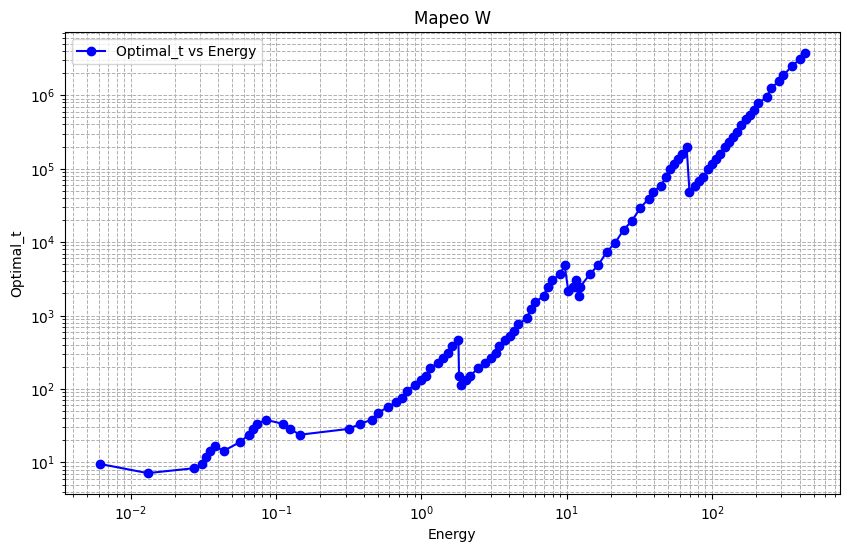

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer el archivo CSV
csv_file = 'MapeoW.csv'
df = pd.read_csv(csv_file)

# Asumir que el archivo tiene columnas 'Energy' y 'Optimal_t'
energy_col = 'Energy'
optimal_t_col = 'Optimal_t'

# Comprobar que las columnas están presentes
if energy_col not in df.columns or optimal_t_col not in df.columns:
    raise ValueError(f"Column '{energy_col}' or '{optimal_t_col}' not found in the CSV file")

# Extraer los datos
energy = df[energy_col].values
optimal_t = df[optimal_t_col].values

# Filtrar valores de 'Optimal_t' adyacentes repetidos, manteniendo 'Energy' correspondiente
def remove_repeated_thickness(x, y):
    filtered_x = []
    filtered_y = []
    last_t = None

    for xi, yi in zip(x, y):
        if yi != last_t:
            filtered_x.append(xi)
            filtered_y.append(yi)
        last_t = yi

    return np.array(filtered_x), np.array(filtered_y)

energy_filtered, optimal_t_filtered = remove_repeated_thickness(energy, optimal_t)

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar los datos filtrados
plt.plot(energy_filtered, optimal_t_filtered, 'o-', color='blue', label='Optimal_t vs Energy')

# Configurar escalas logarítmicas
plt.xscale('log')
plt.yscale('log')

# Etiquetas y título
plt.xlabel('Energy')
plt.ylabel('Optimal_t')
plt.title('Mapeo W')
plt.legend()

# Mostrar la cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# # Guardar el gráfico como archivo PNG
# plt.savefig('filtered_log_log_plot.png')

# Mostrar el gráfico
plt.show()
